# Generation of synthetic promoters for *C. cinerea* from upstream sequences
## Purpose
This notebook extracts upstream sequences from the *C. cinerea* genome and trains a neural generator. It then generates synthetic promoters based on this generator.
## Extraction of upstream sequences

In [1]:
#load required libraries
import pandas as pd
from Bio import BiopythonParserWarning, BiopythonDeprecationWarning #gider ik advarsler
import os
import os
import sys
import warnings
import torch
import sys, pathlib
import  numpy as np
os.chdir("..") #change directory to root for relative improrts
proj_root = pathlib.Path(r"c:\Users\alexa\OneDrive - Danmarks Tekniske Universitet\27460 - Syntesebiologi\Exam\27460_synthetic_promoters").resolve()
sys.path.insert(0, str(proj_root))

The custom function to extract upstream sequences from and annotated genome is imported from `utils` module

In [2]:
#import from utils module
from src.utils import extract_upstream_sequences, one_hot_encode_df_to_tensor

In [3]:
warnings.filterwarnings("ignore", category=BiopythonParserWarning) #ignore

upstream_seq_df = extract_upstream_sequences("genome/amutbmut.gbk", 1000, ["CDS"])

In [4]:
print("Length of upstream sequences dataframe:", len(upstream_seq_df))
print("first 5 rows:\n", upstream_seq_df.head(5))

Length of upstream sequences dataframe: 16862
first 5 rows:
             id                                           sequence
0  CC2G_000001  CTCCCAAAAAGCGTAAGTCCTATTCTCTTTCTACTACTATCTTTTG...
1  CC2G_000002  CTTGGCCTTAGTGACAACACCTTGTTCGCCACTGCTCTATCTAACT...
2  CC2G_000003  CAAGCTCTACCGGCGAAGTGATTTGCCAATTCTTCTGTTGCCGGCG...
3  CC2G_000004  TTCAAGTGTTTTATCACAGTATCTAACATCATGACTTCACCGATGG...
4  CC2G_000005  AGACTAGCAAAGACTATAAAACAAACGGAATACATGCGCATGATAC...


## Encoding to tensor with one-hot encoding
We now encode the extracted sequences to a tensor in preparation for machine learning

In [5]:
seq_tensor:torch.Tensor = one_hot_encode_df_to_tensor(upstream_seq_df, 1000, "sequence") #pylance gets confused wo type annotation
print(seq_tensor.shape)

torch.Size([16862, 4, 1000])


The encoded tensor has the expected size 

### Dispaying the tensor for our slides

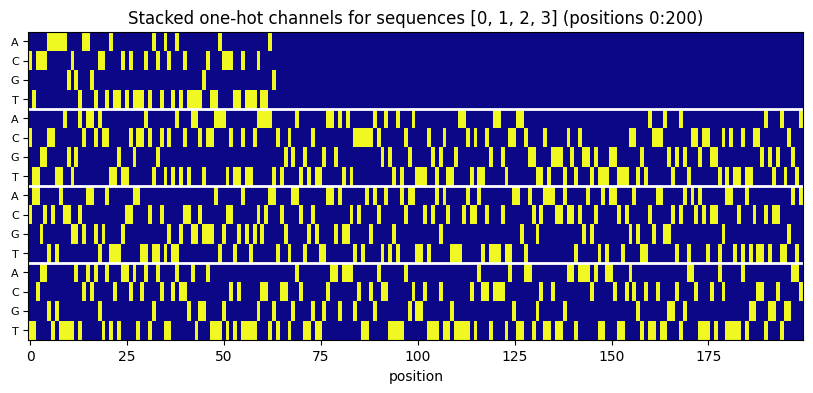

In [7]:
from src.utils import tensor_tile_for_ppt
import matplotlib.pyplot as plt

fig = tensor_tile_for_ppt(seq_tensor, seq_selector=slice(0,4), pos_slice=(0,200), channel_order="ACGT", layout="stack", cmap="plasma")
plt.show()

## Preparation

### GPU initialization and status

In [ ]:
if torch.cuda.is_available():
    dev = torch.device('cuda')
    print("CUDA available. Device:", torch.cuda.current_device(), "-", torch.cuda.get_device_name(0))
else:
    dev = torch.device('cpu')
    print("CUDA not available")

if dev.type == 'cuda':
    torch.cuda.synchronize()
    print("GPU forward/backward synchronized")

CUDA available. Device: 0 - NVIDIA GeForce RTX 3060 Laptop GPU
GPU forward/backward synchronized


### Neural network setup
A model similar to the one used in [Synthetic-promoters-via-GAN repo](https://github.com/TokaMamdoh/Synthetic-promoters-via-GAN) is utilized. Our model is simpler and runs for around 100 epochs compared to 500 used in the original project.

In [6]:
from src.utils import Generator, Critic, SelfAttentionLayer, Initialize_weights, GradientPenalty, ensure_length_match, WGANGPLossG, WGANGPLossD

### Training

In [7]:
log_interval = 50 # for logging to check for convergence
loss_critic_history = []
loss_gen_history = []
loss_epoch_history = []

save_model_interval = 5  # epochs

import torch
from torch.utils.data import TensorDataset, DataLoader



# instantiate used names
lossD = WGANGPLossD()
lossG = WGANGPLossG()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

assert 'seq_tensor' in globals(), "seq_tensor not found; run encoding cell"
seq_channels = int(seq_tensor.shape[1])
seq_len = int(seq_tensor.shape[2])

Batch_size = globals().get('Batch_size', 32)
noise_dim = globals().get('noise_dim', 100)
features_gen = globals().get('features_gen', 64)
features_critic = globals().get('features_cirtic', globals().get('features_critic', 64))
num_epochs = globals().get('num_epochs', 100)
Critic_iterations = globals().get('Critic_iterations', 5)
Learning_rate = globals().get('Learning_rate', 1e-4)
Lamda_GP = globals().get('Lamda_GP', 10.0)

assert 'lossD' in globals() and 'lossG' in globals(), "Define lossD and lossG before training"

In [ ]:
dataloader = DataLoader(TensorDataset(seq_tensor), batch_size=Batch_size, shuffle=True, drop_last=True)

gen = Generator(noise_dim, features_gen, SelfAttentionLayer, out_channels=4, target_len=seq_len).to(device)
critic = Critic(seq_channels, features_critic, SelfAttentionLayer).to(device)

Initialize_weights(gen)
Initialize_weights(critic)

opt_gen = torch.optim.Adam(gen.parameters(), lr=Learning_rate, betas=(0.0, 0.9))
opt_critic = torch.optim.Adam(critic.parameters(), lr=Learning_rate, betas=(0.0, 0.9))




# quick forward sanity check
with torch.no_grad():
    test_noise = torch.randn(2, noise_dim, 1, device=device)
    test_fake = gen(test_noise)
print("gen output shape:", test_fake.shape, "critic(gen) shape:", critic(test_fake).shape)

for epoch in range(num_epochs):
    for batch_idx, (real_batch,) in enumerate(dataloader):
        real = real_batch.to(device).float()

        # Train critic multiple times
        for _ in range(Critic_iterations):
            noise = torch.randn(real.size(0), noise_dim, 1, device=device)
            fake = gen(noise)
            fake = ensure_length_match(fake, real)

            critic_real = critic(real).reshape(-1)
            critic_fake = critic(fake.detach()).reshape(-1)

            gp = GradientPenalty(critic, real, fake.detach(), device)
            loss_critic = lossD.Wasserstein(critic_real, critic_fake) + Lamda_GP * gp

            opt_critic.zero_grad()
            loss_critic.backward()
            opt_critic.step()

        # Train generator
        noise = torch.randn(real.size(0), noise_dim, 1, device=device)
        fake = gen(noise)
        fake = ensure_length_match(fake, real)

        critic_fake_for_gen = critic(fake).reshape(-1)
        loss_gen = lossG.Wasserstein(critic_fake_for_gen)

        opt_gen.zero_grad()
        loss_gen.backward()
        opt_gen.step()
        if batch_idx % log_interval == 0:
            loss_critic_history.append(loss_critic.item())
            loss_gen_history.append(loss_gen.item())
            loss_epoch_history.append(epoch)

        if batch_idx % 526 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}] Batch {batch_idx+1}/{len(dataloader)} "
                  f"Loss D: {loss_critic.item():.4f}, Loss G: {loss_gen.item():.4f}")
            
    if (epoch + 1) % save_model_interval == 0 or (epoch == num_epochs - 1): # save model every once in a while
        ckpt_path = f"models/wgan_gp_epoch{epoch+1}.pth"
        try:
            torch.save({
                "epoch": epoch + 1,
                "gen_state_dict": gen.state_dict(),
                "critic_state_dict": critic.state_dict(),
                "opt_gen_state_dict": opt_gen.state_dict(),
                "opt_critic_state_dict": opt_critic.state_dict(),
                "loss_gen": loss_gen.item() if 'loss_gen' in globals() else None,
                "loss_critic": loss_critic.item() if 'loss_critic' in globals() else None,
                "loss_gen_history": loss_gen_history,
                "loss_critic_history": loss_critic_history,
                "loss_epoch_history": loss_epoch_history,
                "target_len": seq_len
            }, ckpt_path)
            print(f"Saved checkpoint: {ckpt_path}")
        except Exception as e:
            print(f"Failed to save checkpoint: {e}")

gen output shape: torch.Size([2, 4, 1000]) critic(gen) shape: torch.Size([2, 1])
Epoch [1/100] Batch 1/526 Loss D: 9.9985, Loss G: -0.0210
Epoch [2/100] Batch 1/526 Loss D: -37.4122, Loss G: 29.4174
Epoch [3/100] Batch 1/526 Loss D: -41.5314, Loss G: 13.7433
Epoch [4/100] Batch 1/526 Loss D: -43.0539, Loss G: 22.1279
Epoch [5/100] Batch 1/526 Loss D: -42.8915, Loss G: 21.6078
Saved checkpoint: models/wgan_gp_epoch5.pth
Epoch [6/100] Batch 1/526 Loss D: -44.9998, Loss G: 15.2985
Epoch [7/100] Batch 1/526 Loss D: -43.2964, Loss G: 21.7242
Epoch [8/100] Batch 1/526 Loss D: -44.3488, Loss G: 23.4805
Epoch [9/100] Batch 1/526 Loss D: -44.7307, Loss G: 24.7043
Epoch [10/100] Batch 1/526 Loss D: -44.0801, Loss G: 22.3314
Saved checkpoint: models/wgan_gp_epoch10.pth
Epoch [11/100] Batch 1/526 Loss D: -44.2532, Loss G: 17.2157
Epoch [12/100] Batch 1/526 Loss D: -44.7779, Loss G: 15.2780
Epoch [13/100] Batch 1/526 Loss D: -45.6576, Loss G: 13.9755
Epoch [14/100] Batch 1/526 Loss D: -44.9635, Los

In [10]:
#save the model and loss history for analysis
torch.save({
    "epoch": epoch,
    "gen_state_dict": gen.state_dict(),
    "critic_state_dict": critic.state_dict(),
    "opt_gen_state_dict": opt_gen.state_dict(),
    "opt_critic_state_dict": opt_critic.state_dict(),
    "loss_gen": loss_gen.item(),
    "loss_critic": loss_critic.item(),
    "loss_gen_history": loss_gen_history,
    "loss_critic_history": loss_critic_history,
    "loss_epoch_history": loss_epoch_history
}, "models/wgan_gp_100_epochs.pth")

df_losses = pd.DataFrame({
    "epoch": loss_epoch_history,
    "loss_critic": loss_critic_history,
    "loss_gen": loss_gen_history
})
print(df_losses.head())

   epoch  loss_critic   loss_gen
0      0     9.998465  -0.020977
1      0     7.620546 -12.251521
2      0     2.511353 -26.511282
3      0     4.349475  -0.520365
4      0    -7.918716  -3.376682


In [ ]:
#save model w target length
torch.save({
    "epoch": epoch,
    "gen_state_dict": gen.state_dict(),
    "critic_state_dict": critic.state_dict(),
    "opt_gen_state_dict": opt_gen.state_dict(),
    "opt_critic_state_dict": opt_critic.state_dict(),
    "loss_gen": loss_gen.item() if 'loss_gen' in globals() else None,
    "loss_critic": loss_critic.item() if 'loss_critic' in globals() else None,
    "loss_gen_history": loss_gen_history,
    "loss_critic_history": loss_critic_history,
    "loss_epoch_history": loss_epoch_history,
    "target_len": seq_len
}, "models/wgan_gp_100_epochs_fixed.pth")
print("Saved fixed checkpoint with target_len")

Saved fixed checkpoint with target_len


### Verifying training

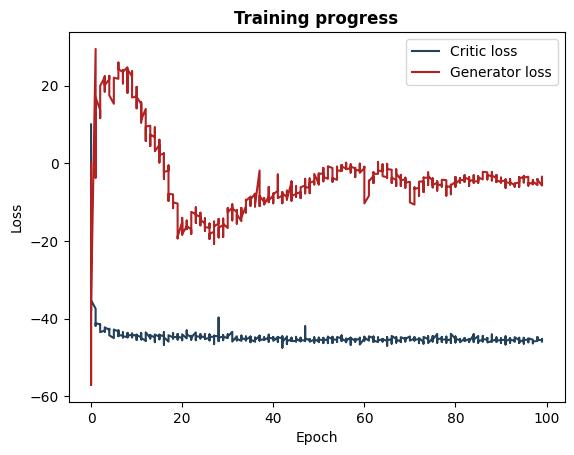

In [20]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(df_losses['epoch'], df_losses['loss_critic'], label='Critic loss', color = "#23415A")
plt.plot(df_losses['epoch'], df_losses['loss_gen'], label='Generator loss', color = "#B22222")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training progress', weight='bold')
plt.legend()
plt.show()

## Generating sequences with the model

In [8]:
from src.utils import generate_from_checkpoint
warnings.filterwarnings("ignore")

generated_sequences = generate_from_checkpoint("models/wgan_gp_100_epochs_fixed.pth", num_sequences=10, noise_dim=noise_dim, device=device, target_len= 1000)
print("Generated sequences:")
for i, seq in enumerate(generated_sequences):
    print(f"Sequence {i+1}: {seq}")

Generated sequences:
Sequence 1: CACTGGGTATCAGGACCTCTCGCTAGATGTCCGGTAGTGGGAAATGACGAATGAGAGAAAGCGTAGTGGGAAACGTTTCGTATATTCACGCGGGATAGATCTTATAACGTTCTCCTCAGTGGCGACACGTGGAACCACCCCCCGTATATAGCTGTTATCGTCACGGGCCCGCCGACCTGCATTGCAAACCCTGACGTAGCTAATACTACTGCCGATTGCAGTAGCAATCTGACATGAACTCCAGATAGTGAAAACACCCTACGTGGCTCCACCTGGCCTAATCTAACAGAATACTTGCCGACGATGAACTTCTGATACGTAGACCGTTGATTCGGTCTAACGCGGTTGAGAATCTACACCGTTGTCTTTTTGTGCCGTTCAACGACTAGAGTCGACCTGGACATACGTTGATGTGTAGTCAAAGGTGATTCATAGTTTTTAGATTAAGTTGTGACGGTAGTTGCGCTGTTATAACATATAGCTCCCCCTCTCTTCGTGATAGATTATTGGACCCCCTCGTCTATCTGTGTTAGAACGTTTACAGCGGTCTGAAATTTGAGTTGTAGTATCATGTCAACACGAGGGCCCCCGGTAAAGCAGGACAATCGTATCGTGTATTTTCGCGATGCAATTCTATAACGACCCTAATATCCTGTTTGGGCAGCGACAATCAGGTCCAGTCGGGCGTCAAATTGAATAACCAGCATCTGATGGGTATTCTTGTTATGCATGTTAGTATGACTACCATCAACAGCGCGTCGGGCGGCTGGTTGGTCTGACTGCGTTGGAGTTGTACGGGACATGCGCCCGTCGGAGATACCTCGGTAGGGCCCGTGTTGGTAGTCGTAACCCAAAAAGGGTAAAACATGTGCACGGTCTTGTGCCTCCGGGTTGCACGGGTACGCGTTTGAGTCGCATTAAACGGCTTGAAGGAAGGCGGGCTGATTTGGTTGCGTGCTGATATTAG

## Generating the sequences and saving them

In [11]:
import numpy as np
path = "data/generated_promoters/generated_sequences.fasta"
decode = "sample" #so its stochastic and not most probable'
i = 0
for temp in (np.linspace(0.1, 5.0, 50)): #varying sampling temperature
    seqs = generate_from_checkpoint("models/wgan_gp_100_epochs_fixed.pth", num_sequences=1, noise_dim=noise_dim, device=device, target_len=1000, temperature=temp, decode=decode)
    with open(path, "a") as f:
        f.write(f"\n>synthetic_temp={temp:.2f}\n")
        f.write(seqs[0])
    i += 1
print(f"saved {i} sequences")

saved 50 sequences


We can have a look at the head of the file:

In [26]:
with open(path, "r") as fh:
    for i, line in enumerate(fh):
        print(line.rstrip())
        if i + 1 >= 6:
            break


>synthetic_temp=0.10
TCACACCTTAGTGACCGGCCTTCCAGGTCGCGCACATTTTCGAATCGCCGCAATAGCGCGCAGTCGACCCGGCACATACCCATAGCAAGACGTTTACGGAACTCTTCAAGAGCTCAAACGTGTATAGGGGGTATTGGTGTGCATACCCCCGGTCCGCTCGCGCCGTGGCGGCTCAACCGGTTGATGGGTTGCCCCCCTCGGACCTTAATGGAGCTGGAATTGGAAGACAAATGTGTTACATATGTTCTTCGAGCAAACTCGGTATAGTACAAGCCAACCGAGACCACCGGAGGTAGTTCATTTCACGCACGTAGACGTGAAACCCTGTTGCGTCTACCCATATCTGGTCTGGTTGGTGTTTTACGAGTAATGGGTCGTTCGCTTAGTTCACAATGCGTTATGAGTCACATGAACGGTTGTAATAGATCATGTGAATAAGTGTTGCTGATGACGCGCGCGCATGGGTGAGGTGTTCTACAGCTGGGGGTCGGTGAGAAGTGGTAGATCGGGGTTTGGCAGGTCTAATACATTCGGGTCTTTTGATTTCGGAGTAGTTATTGTTGTGTGCCAGATGTGTGTATGTGGTTACGATAACAGCAATTTTTCGCGGGTGGCTGAGCGGCTGCCATCCTACGTTTTCGGGAGGAGTCACCCCATGCTGAGACGAAAAGGTACCATGGCGAGCCAATCATCTCGACAATGTTTATCTTCAACGACAGATGCAAATCCATCGCGTGGAAGCACAGAGAACCGAGGCCGCAAGGATATGTAATTACCTATGAGAGACTTAGAAATGGAAACAATACCCAGCTGAGGTTCAAAAACACAACTATAACACCGGAAATCATAATTACCAAGTTCAACTACAGATTCAATGAACACTAGCGTATAAGCCAATAAAGACGCAGAATAGAAGCAGTAGAACACAGACAAGAGAAGGTACATACGTGAAAACCAACCCAACCGATCCAACGCCCA

## Ranking generated synthetic promoters using Promoter 2.0
The generated sequences are ranked using DTU Healthtechs Promoter 2.0, which predicts PolII promoter start site in vertebrates. Though this is not exactly suitable for *C. cinerea* we will still utilize it as we hope it provides some way to screen the promoters for a start site. For this project, we limited the screening to 50 promoter sequences, which is the maximum allowed by the service. It would technically be possible to screen larger datasets by splitting them into batches of 50, such an approach would place unnecessary strain on the server. Developing the project further would require access to larger screenings with Promoter 2.0 or a similar service (ideally intended for fungal). To be able to screen such an output a utility function `parse_result` is made to extract ID and score from the Promoter 2.0 output. It is used below and the resulting df is then sorted and the results with the ten highest scores are extracted: 

In [8]:
from src.utils import parse_results
results_df = parse_results("data/generated_promoters/promoter_2.0_results.txt") #parse the result
print("Top 10 promoters as ranked by Promoter 2.0:\n")
print(results_df[["name", "score", "positions"]].sort_values(by="score", ascending=False).head(10))

Top 10 promoters as ranked by Promoter 2.0:

                   name  score   positions
17  synthetic_temp_2.50  1.115       [400]
32  synthetic_temp_3.90  1.107  [500, 800]
7   synthetic_temp_1.60  1.090  [200, 800]
9   synthetic_temp_1.80  1.090       [500]
44  synthetic_temp_0.50  1.076       [500]
29  synthetic_temp_3.60  1.043       [600]
24  synthetic_temp_3.10  0.744       [400]
23  synthetic_temp_3.00  0.741       [600]
27  synthetic_temp_3.40  0.737       [300]
28  synthetic_temp_3.50  0.719       [600]


### Saving top 10 promoters to fasta

In [ ]:
warnings.filterwarnings("ignore", category=BiopythonDeprecationWarning)

from src.utils import filter_fasta_by_names
filter_fasta_by_names(
    fasta_in="data/generated_promoters/generated_sequences.fasta",
    names_df=results_df.sort_values(by="score", ascending=False).head(10),
    out_fasta="data/generated_promoters/top_10_promoters.fasta",
    name_col="name",
    match_on_description=False
)

{'written': 10,
 'found': {'0.50',
  '1.60',
  '1.80',
  '2.50',
  '3.00',
  '3.10',
  '3.40',
  '3.50',
  '3.60',
  '3.90'},
 'missing': []}